In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import numpy as np
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)  # suppress warnings
import random

In [3]:
SEED = 123

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [31]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30

# Loading the Dataset

In [32]:
dataset  = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/ML Implementation/Corn-disease/corn_disease_dataset/data",
     shuffle = True,
     seed=SEED,
     image_size = (IMAGE_SIZE, IMAGE_SIZE),
     batch_size = BATCH_SIZE
)

Found 4814 files belonging to 4 classes.


In [33]:
class_names = dataset.class_names
class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [34]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

(32, 224, 224, 3)
[3 2 1 2 1 1 0 3 0 1 1 1 1 1 2 2 3 2 0 2 2 0 2 1 3 1 0 1 2 1 1 2]


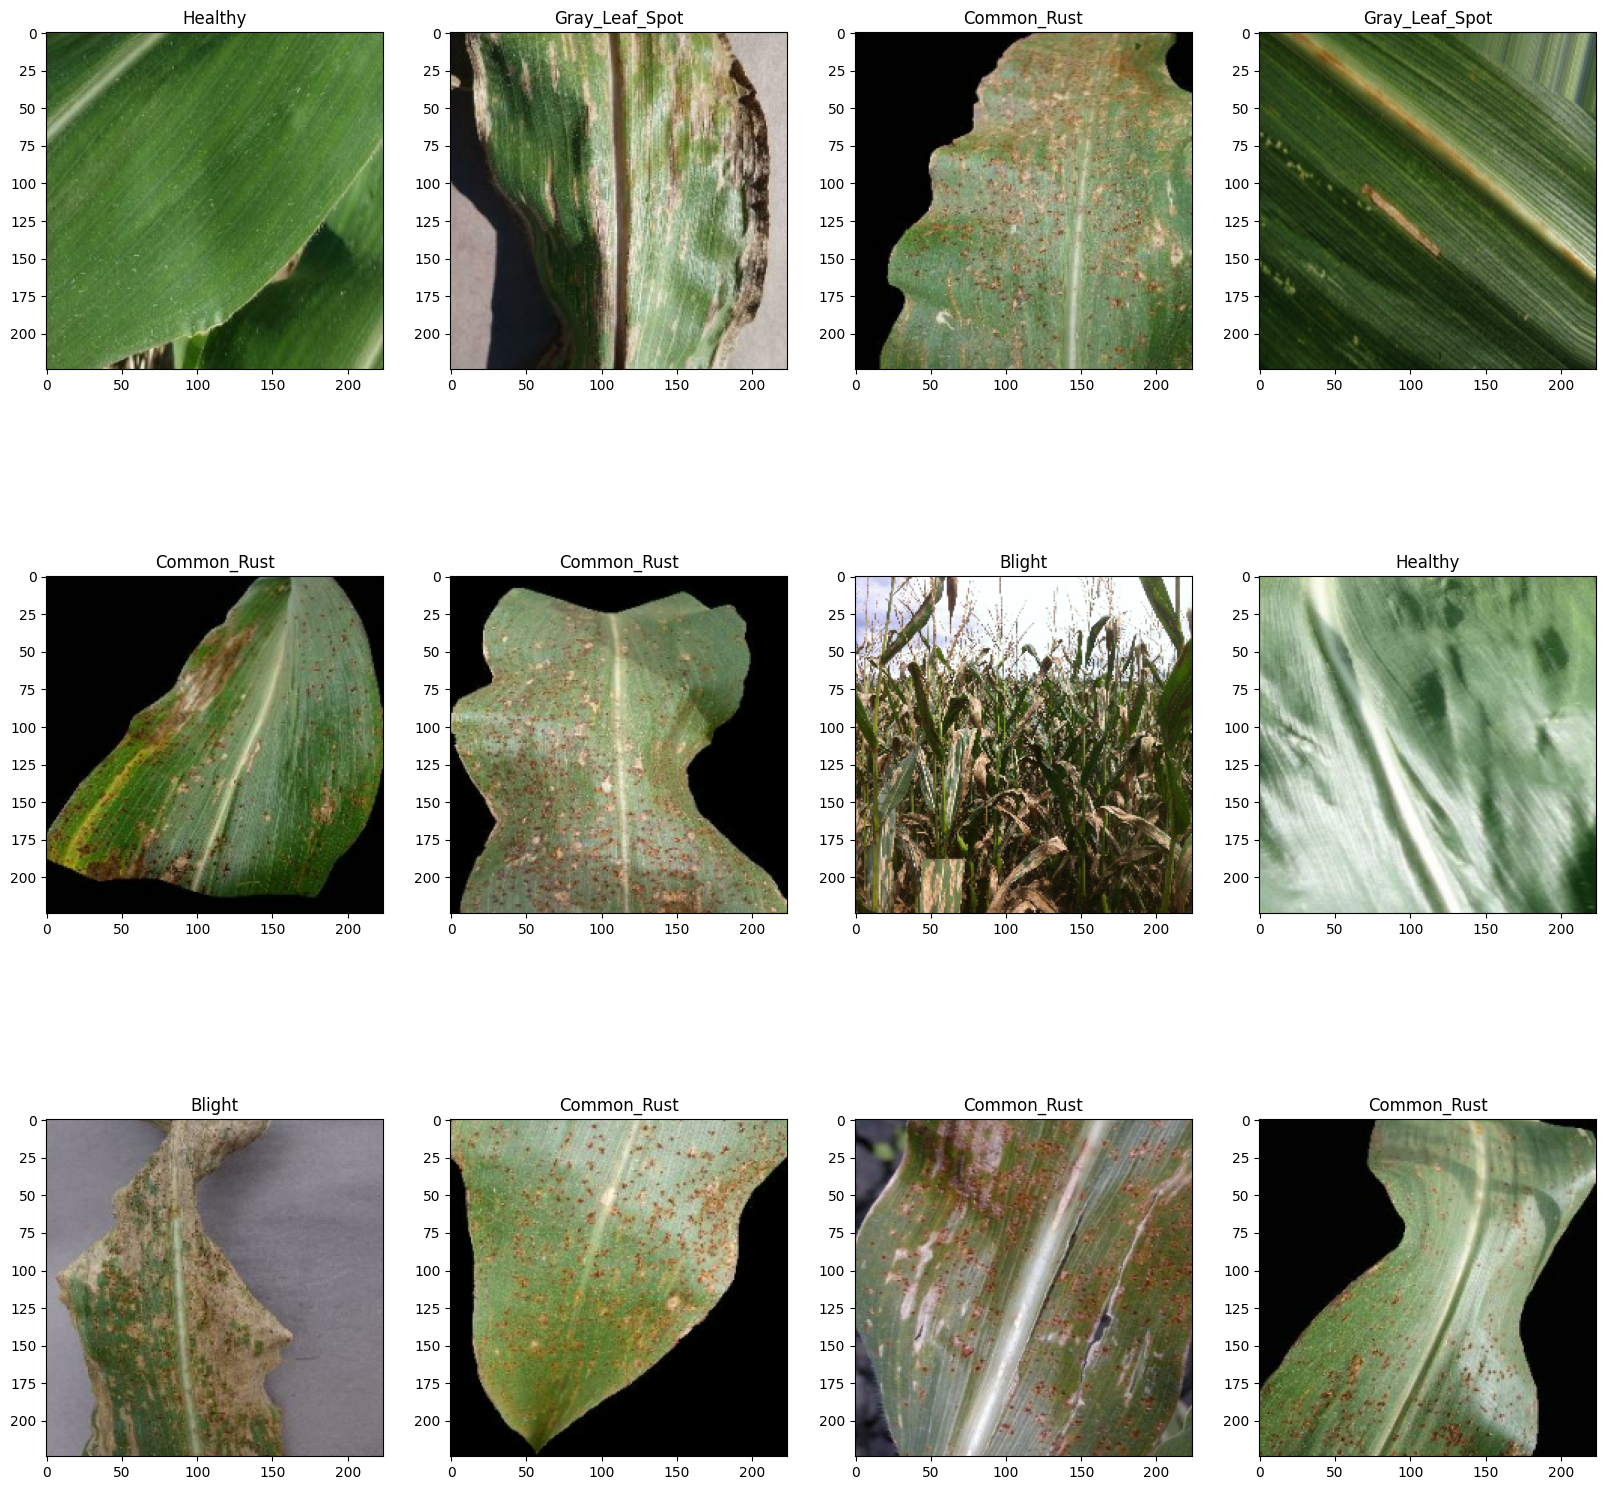

In [35]:
plt.figure(figsize = (20,20)) # Lets increse plot size of our plots
#Lets explore our batch and display some images
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
    #To visualize all images plot as subplot 
        ax = plt.subplot(3,4,i+1)
    #Visualize image using matplotlib imshow function plt.imshow expects a 3D numpy array
        plt.title(class_names[label_batch[i]]) # Displaying its class label as title
        plt.imshow(image_batch[i].numpy().astype('uint8'))
    print(image_batch.shape)
    print(label_batch.numpy())

In [36]:
y = np.concatenate([y for x, y in dataset], axis=0)
print(np.bincount(y))#np.bincount(array) counts occurence of each element in array.

[1146 1306 1200 1162]


# Data Partition

In [37]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    # Count dataset size
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=SEED)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)
    return train_ds, val_ds, test_ds

In [38]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [39]:
len(train_ds)

120

In [40]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Data Rescaling & Augmentation

In [41]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1./255)
])

In [42]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

In [43]:
# Train: resize → augment → cache → prefetch
train_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [44]:
# Val/test: resize → cache → prefetch (no augmentation)
val_ds = val_ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = test_ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Loading the Model : GoogleNet

In [50]:
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D,
    Flatten, Dropout, Dense, Input, BatchNormalization, Concatenate
)
from tensorflow.keras.models import Model

NUM_CLASSES = 4  # ✅ number of classes = 4

def inceptionnet(x, filters, name=None):
    # 1x1 conv
    path1 = Conv2D(filters[0], (1,1), padding='same', activation='relu')(x)
    
    # 1x1 conv + 3x3 conv
    path2 = Conv2D(filters[1][0], (1,1), padding='same', activation='relu')(x)
    path2 = Conv2D(filters[1][1], (3,3), padding='same', activation='relu')(path2)
    
    # 1x1 conv + 5x5 conv
    path3 = Conv2D(filters[2][0], (1,1), padding='same', activation='relu')(x)
    path3 = Conv2D(filters[2][1], (5,5), padding='same', activation='relu')(path3)
    
    # 3x3 maxpool + 1x1 conv
    path4 = MaxPooling2D((3,3), strides=1, padding='same')(x)
    path4 = Conv2D(filters[3], (1,1), padding='same', activation='relu')(path4)
    
    return Concatenate(axis=-1, name=name)([path1, path2, path3, path4])

def helperfunction(x, name=None):
    x = AveragePooling2D((5,5), strides=3)(x)
    x = Conv2D(128, (1,1), activation='relu')(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(NUM_CLASSES, activation='softmax', name=name)(x)
    return x

def googlenet(input_shape=(224,224,3)):
    inputs = Input(shape=input_shape)
    
    # Stem
    x = Conv2D(64, (7,7), strides=2, padding='same', activation='relu')(inputs)
    x = MaxPooling2D((3,3), strides=2, padding='same')(x)
    x = BatchNormalization()(x)

    x = Conv2D(64, (1,1), activation='relu')(x)
    x = Conv2D(192, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3,3), strides=2, padding='same')(x)

    # Inception blocks + auxiliary classifiers
    x = inceptionnet(x, [64, (96,128), (16,32), 32], name='inception_3a')
    x = inceptionnet(x, [128, (128,192), (32,96), 64], name='inception_3b')
    x = MaxPooling2D((3,3), strides=2, padding='same')(x)

    x = inceptionnet(x, [192, (96,208), (16,48), 64], name='inception_4a')
    aux1 = helperfunction(x, name='aux_output_1')

    x = inceptionnet(x, [160, (112,224), (24,64), 64], name='inception_4b')
    x = inceptionnet(x, [128, (128,256), (24,64), 64], name='inception_4c')
    x = inceptionnet(x, [112, (144,288), (32,64), 64], name='inception_4d')
    aux2 = helperfunction(x, name='aux_output_2')

    x = inceptionnet(x, [256, (160,320), (32,128), 128], name='inception_4e')
    x = MaxPooling2D((3,3), strides=2, padding='same')(x)

    x = inceptionnet(x, [256, (160,320), (32,128), 128], name='inception_5a')
    x = inceptionnet(x, [384, (192,384), (48,128), 128], name='inception_5b')

    # GlobalAveragePooling + final dense layer
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    final = Dense(NUM_CLASSES, activation='softmax', name='main_output')(x)

    # Build model
    model = Model(inputs=inputs, outputs=[final, aux1, aux2], name='GoogLeNet')
    return model

In [51]:
model = googlenet()
model.summary()


Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_236 (Conv2D)         (None, 112, 112, 64)         9472      ['input_5[0][0]']             
                                                                                                  
 max_pooling2d_52 (MaxPooli  (None, 56, 56, 64)           0         ['conv2d_236[0][0]']          
 ng2D)                                                                                            
                                                                                                  
 batch_normalization_8 (Bat  (None, 56, 56, 64)           256       ['max_pooling2d_52[0][

In [55]:
learning_rate = 0.001
opti = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(
    loss=['sparse_categorical_crossentropy', 'sparse_categorical_crossentropy', 'sparse_categorical_crossentropy'],
    loss_weights=[1, 0.3, 0.3],
    optimizer=opti,
    metrics=['accuracy']
)


In [56]:
# Callbacks
from tensorflow.keras import callbacks


early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)
model_ckpt = callbacks.ModelCheckpoint(
    filepath="best_googlenet.h5",  # or best_alexnet.keras if using latest version
    save_best_only=True,
    monitor="val_loss"
)

In [57]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop, reduce_lr, model_ckpt]
)

Epoch 1/20
120/120 [==============================] - ETA: 0s - loss: 1.0494 - main_output_loss: 0.6866 - aux_output_1_loss: 0.5683 - aux_output_2_loss: 0.6411 - main_output_accuracy: 0.6999 - aux_output_1_accuracy: 0.7737 - aux_output_2_accuracy: 0.7111

C:\ML Implementation\Corn-disease\corn_env\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


120/120 [==============================] - 266s 2s/step - loss: 1.0494 - main_output_loss: 0.6866 - aux_output_1_loss: 0.5683 - aux_output_2_loss: 0.6411 - main_output_accuracy: 0.6999 - aux_output_1_accuracy: 0.7737 - aux_output_2_accuracy: 0.7111 - val_loss: 2.5004 - val_main_output_loss: 1.6841 - val_aux_output_1_loss: 1.2341 - val_aux_output_2_loss: 1.4870 - val_main_output_accuracy: 0.3083 - val_aux_output_1_accuracy: 0.3896 - val_aux_output_2_accuracy: 0.3042 - lr: 0.0010
Epoch 2/20
120/120 [==============================] - 247s 2s/step - loss: 0.5926 - main_output_loss: 0.3761 - aux_output_1_loss: 0.3531 - aux_output_2_loss: 0.3684 - main_output_accuracy: 0.8354 - aux_output_1_accuracy: 0.8467 - aux_output_2_accuracy: 0.8388 - val_loss: 2.0159 - val_main_output_loss: 1.3540 - val_aux_output_1_loss: 1.0224 - val_aux_output_2_loss: 1.1838 - val_main_output_accuracy: 0.5146 - val_aux_output_1_accuracy: 0.5437 - val_aux_output_2_accuracy: 0.5333 - lr: 0.0010
Epoch 3/20
120/120 [===

In [63]:
acc = history.history['main_output_accuracy']
val_acc = history.history['val_main_output_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


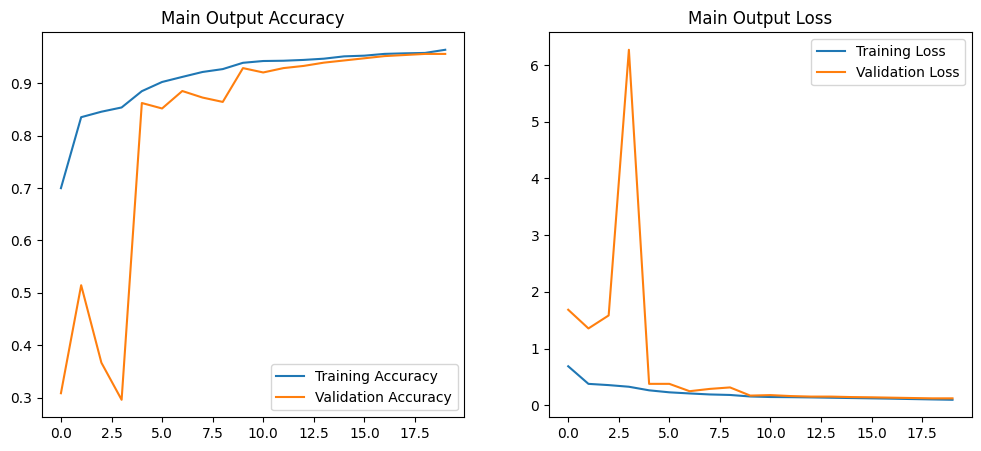

In [64]:
plt.figure(figsize = (12,5))

plt.subplot(1,2,1)
plt.plot(history.history['main_output_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_main_output_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Main Output Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['main_output_loss'], label='Training Loss')
plt.plot(history.history['val_main_output_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Main Output Loss')

plt.show()


first image to print


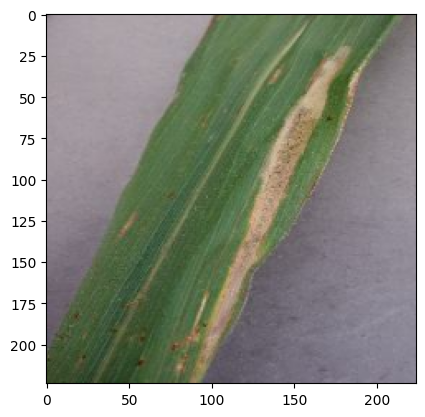

first image actual label: Blight
1/1 [==============================] - 0s 494ms/step
predicted label: Blight


In [67]:
for image_batch, label_batch in test_ds.take(1):
    first_image = (image_batch[0].numpy() * 255).astype('uint8')
    first_label = label_batch[0].numpy()

    print("first image to print")
    plt.imshow(first_image)
    plt.show()

    print("first image actual label:", class_names[first_label])

    # predict on batch: returns list [main_output, aux_output_1, aux_output_2]
    batch_prediction = model.predict(image_batch)

    # get main output predictions
    main_predictions = batch_prediction[0]

    # get the prediction vector for the first image
    first_pred = main_predictions[0]

    # get predicted class index
    predicted_class_idx = np.argmax(first_pred)

    print("predicted label:", class_names[predicted_class_idx])


In [70]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img, )
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 36ms/step


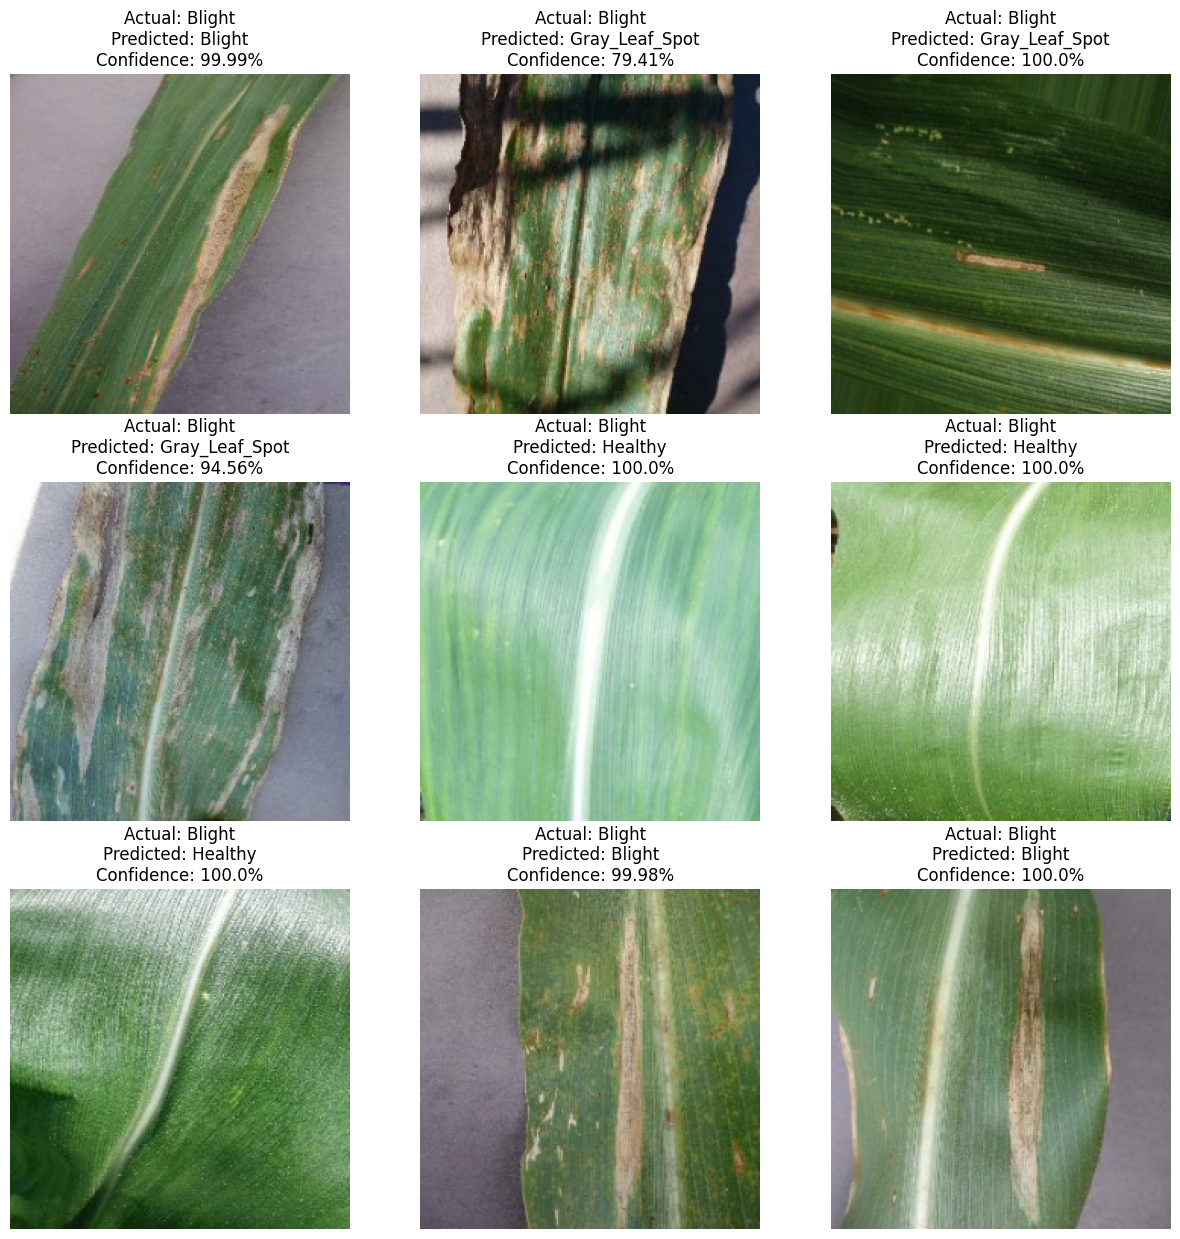

In [71]:
plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)

        # rescale for display
        display_image = (images[i].numpy() * 255).astype("uint8")
        plt.imshow(display_image)
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[predicted_class_idx] 
        
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis("off")


# Model Predictions

In [72]:
import numpy as np

y_true = []
y_pred = []
y_prob = []

for images, labels in val_ds:
    preds_list = model.predict(images)
    preds = preds_list[0]  # main_output predictions: shape (batch_size, num_classes)
    
    preds_classes = np.argmax(preds, axis=1)  # shape (batch_size,)
    true_classes = labels.numpy()

    y_true.extend(true_classes)
    y_pred.extend(preds_classes)
    y_prob.extend(preds)  # add the raw probabilities

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)


1/1 [==============================] - 1s 527ms/step


In [73]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

# Accuracy

In [74]:
acc = accuracy_score(y_true, y_pred)

In [75]:
print(f"Accuracy: {acc * 100:.2f}%")

Accuracy: 95.62%


# Precision

In [76]:
precision = precision_score(y_true, y_pred, average='weighted')  # or 'macro', 'micro'

In [77]:
print(f"Precision: {precision * 100:.2f}%")

Precision: 95.67%


# Recall

In [78]:
recall = recall_score(y_true, y_pred, average='weighted')

In [79]:
print(f"Recall: {recall * 100:.2f}%")

Recall: 95.62%


# F1-Score

In [80]:
f1 = f1_score(y_true, y_pred, average='weighted')

In [81]:
print(f"f1: {f1 * 100:.2f}%")

f1: 95.61%


# Confusion Matrix

In [82]:
cm = confusion_matrix(y_true, y_pred)

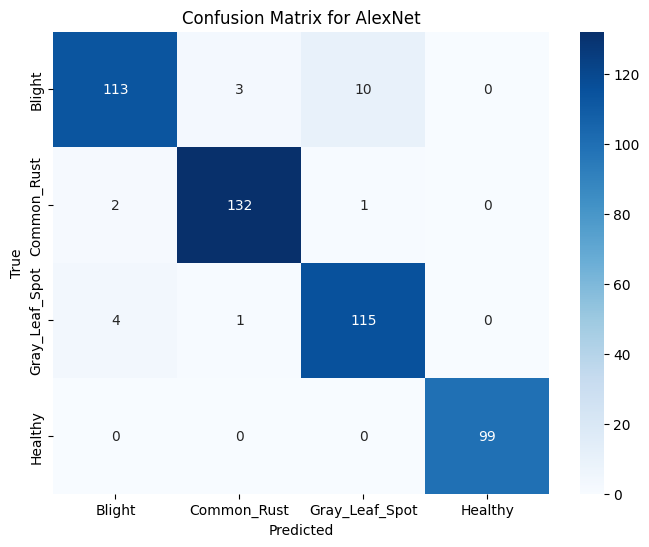

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for AlexNet')
plt.show()


# AUROC

In [84]:
from sklearn.metrics import roc_auc_score

try:
    auc_score = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro') * 100
    print(f"Macro-Averaged ROC-AUC Score: {auc_score:.2f}%")
except Exception as e:
    print("ROC AUC not available:", e)


Macro-Averaged ROC-AUC Score: 99.61%


In [85]:
import os
print("Current working directory:", os.getcwd())

Current working directory: C:\ML Implementation\Corn-disease


In [86]:
model_version= "GoogleNet_224"
model.save(f"./models/{model_version}.keras")